In [8]:
import numpy as np
import pandas as pd
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch
from datasets import load_dataset
from transformers import AutoTokenizer
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset
from collections import Counter
import re
from torch.nn.utils.rnn import pad_sequence
import requests
import tarfile
import io


In [9]:

# https://www.kaggle.com/datasets/amananandrai/ag-news-classification-dataset

In [10]:

class AG_NEWS_Dataset(Dataset):
    def __init__(self, data, vocab, transform=None):
        self.data = data
        self.vocab = vocab
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        label, text = self.data[idx]
        if self.transform:
            text = self.transform(text)
        numerical_text = [self.vocab.get(word, self.vocab['<unk>']) for word in text] #Corrected line
        return torch.tensor(label, dtype=torch.int64), torch.tensor(numerical_text, dtype=torch.int64)

def clean_text(text):
    text = re.sub(r'[^\w\s]', '', text)
    text = text.lower()
    return text.split()

def build_vocab(data, min_freq=30):
    counter = Counter()
    for _, text in data:
        counter.update(clean_text(text))
    vocab = {word: idx + 2 for idx, (word, count) in enumerate(counter.items()) if count >= min_freq}
    vocab['<pad>'] = 0
    vocab['<unk>'] = 1
    return vocab


def load_ag_news(root='.'):
    """
    Load AG News dataset from HuggingFace datasets.
    Returns train_data and test_data as lists of (label, text) tuples.
    """
    from datasets import load_dataset
    
    # Load dataset from HuggingFace
    dataset = load_dataset('ag_news')
    
    train_data = []
    test_data = []
    
    # Convert to expected format: list of (label, text) tuples
    for item in dataset['train']:
        train_data.append((item['label'], item['text']))
    
    for item in dataset['test']:
        test_data.append((item['label'], item['text']))
    
    return train_data, test_data


def collate_batch(batch, pad_idx=0):
    labels, texts = zip(*batch)
    padded_texts = pad_sequence(texts, batch_first=True, padding_value=pad_idx)
    labels = torch.stack(labels)
    return labels, padded_texts

def get_dataloaders(batch_size=64, min_freq=30, root='.'):
    train_data, test_data = load_ag_news(root)
    vocab = build_vocab(train_data, min_freq)

    train_dataset = AG_NEWS_Dataset(train_data, vocab, transform=clean_text)
    test_dataset = AG_NEWS_Dataset(test_data, vocab, transform=clean_text)

    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=lambda batch: collate_batch(batch, pad_idx=vocab['<pad>']))
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=lambda batch: collate_batch(batch, pad_idx=vocab['<pad>']))

    return train_dataloader, test_dataloader, vocab, 4


train_loader, test_loader, vocabulary, num_classes = get_dataloaders()

for labels, texts in train_loader:
    print("Batch Labels:", labels.shape, labels)
    print("Batch Texts:", texts.shape, texts)
    print("Vocab Size:", len(vocabulary))
    print("Number of Classes:", num_classes)
    break

Batch Labels: torch.Size([64]) tensor([3, 2, 3, 0, 3, 3, 3, 3, 1, 2, 0, 1, 2, 1, 1, 1, 1, 3, 3, 1, 2, 3, 2, 0,
        1, 1, 1, 1, 0, 2, 0, 0, 2, 1, 1, 0, 0, 1, 0, 2, 2, 2, 0, 3, 1, 0, 2, 0,
        2, 0, 2, 1, 0, 0, 1, 2, 1, 1, 3, 0, 1, 3, 1, 0])
Batch Texts: torch.Size([64, 58]) tensor([[ 9124,  4917,  2019,  ...,     0,     0,     0],
        [   97,    49,  1103,  ...,     0,     0,     0],
        [ 3922,  8483,  1451,  ...,     0,     0,     0],
        ...,
        [ 1827,  8856,    30,  ...,     0,     0,     0],
        [ 3123,  7214, 10428,  ...,     0,     0,     0],
        [11172, 15041,   200,  ...,     0,     0,     0]])
Vocab Size: 10845
Number of Classes: 4


In [47]:
example = next(enumerate(train_loader))

In [48]:
example

(0,
 (tensor([0, 2, 0, 0, 0, 3, 0, 1, 2, 3, 0, 2, 3, 1, 0, 1, 0, 0, 0, 2, 1, 1, 0, 3,
          2, 3, 0, 0, 0, 0, 2, 2, 3, 1, 2, 3, 2, 2, 1, 0, 1, 0, 3, 2, 0, 1, 2, 1,
          2, 1, 1, 3, 2, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 3]),
  tensor([[ 3223,   436,   175,  ...,     0,     0,     0],
          [ 3316,  7447, 10867,  ...,     0,     0,     0],
          [ 2099,    14,  3733,  ...,     0,     0,     0],
          ...,
          [26326,  3454,   700,  ...,     0,     0,     0],
          [24342,   168,     1,  ...,     0,     0,     0],
          [ 4230,  9979,     1,  ...,     0,     0,     0]])))

In [49]:
example[1]

(tensor([0, 2, 0, 0, 0, 3, 0, 1, 2, 3, 0, 2, 3, 1, 0, 1, 0, 0, 0, 2, 1, 1, 0, 3,
         2, 3, 0, 0, 0, 0, 2, 2, 3, 1, 2, 3, 2, 2, 1, 0, 1, 0, 3, 2, 0, 1, 2, 1,
         2, 1, 1, 3, 2, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 3]),
 tensor([[ 3223,   436,   175,  ...,     0,     0,     0],
         [ 3316,  7447, 10867,  ...,     0,     0,     0],
         [ 2099,    14,  3733,  ...,     0,     0,     0],
         ...,
         [26326,  3454,   700,  ...,     0,     0,     0],
         [24342,   168,     1,  ...,     0,     0,     0],
         [ 4230,  9979,     1,  ...,     0,     0,     0]]))

In [12]:
#Helpers 
def train(model, iterator, optimizer, criterion, device):
    epoch_loss = 0
    epoch_acc = 0
    model.train()
    batch_counter = 0
    for labels, texts in iterator:
        batch_counter = batch_counter + 1
        if batch_counter % 1000 == 0:
            print(batch_counter)
        labels = labels.to(device)
        texts = texts.to(device)
        texts[texts >= VOCAB_SIZE] = UNK_IDX
        optimizer.zero_grad()
        predictions = model(texts)
        loss = criterion(predictions, labels)
        acc = calculate_accuracy(predictions, labels)

        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

def evaluate(model, iterator, criterion, device):
    epoch_loss = 0
    epoch_acc = 0
    model.eval()

    with torch.no_grad():
        for labels, texts in iterator:
            labels = labels.to(device)
            texts = texts.to(device)
            texts[texts >= VOCAB_SIZE] = UNK_IDX
            predictions = model(texts)
            loss = criterion(predictions, labels)
            acc = calculate_accuracy(predictions, labels)

            epoch_loss += loss.item()
            epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

def calculate_accuracy(predictions, labels):
    _, predicted_classes = torch.max(predictions, 1)
    correct_predictions = (predicted_classes == labels).sum().float()
    accuracy = correct_predictions / labels.size(0)  # Corrected line
    return accuracy


In [13]:
# Start with a Vanilla RNN
class VanillaRNN(nn.Module):
    def __init__(self,vocab_size, embed_size, hidden_size, output_size,pad_idx):
        super(VanillaRNN, self).__init__()

        self.embedding = nn.Embedding(vocab_size, embed_size,padding_idx=pad_idx)
        self.hidden_size = hidden_size
        
        self.W_ih = nn.Parameter(torch.Tensor(embed_size, hidden_size)) #Weights Input to hidden
        self.W_hh = nn.Parameter(torch.Tensor(hidden_size, hidden_size)) #Weights Hidden to hidden
        self.b_ih = nn.Parameter(torch.Tensor(hidden_size)) #Bias input to Hidden
        self.b_hh = nn.Parameter(torch.Tensor(hidden_size)) #Bias hidden to hidden
        
        # Define a simple linear layer for the output.
        self.fc = nn.Linear(hidden_size, output_size)
        
        self.reset_parameters()
        
    def reset_parameters(self):
        stdv = 1.0 / (self.hidden_size ** 0.5)
        for weight in self.parameters():
            weight.data.uniform_(-stdv, stdv)
            
    def forward(self, x, hidden=None):
        """
        x: Tensor of shape (batch_size, seq_len) (token indices)
        hidden: Tensor of shape (batch_size, hidden_size)
        """
        batch_size, seq_len = x.size()  # Expect only 2D input (batch, seq_len)

        if hidden is None:
            hidden = torch.zeros(batch_size, self.hidden_size, device=x.device, requires_grad=True)

        # Embed the token indices into a 3D tensor (batch_size, seq_len, embed_size)**
        x = self.embedding(x)

        # Process sequence one timestep at a time
        hidden_states = []
        for t in range(seq_len):
            x_t = x[:, t, :]  # Shape: (batch_size, embed_size)
            hidden = torch.tanh(x_t @ self.W_ih + self.b_ih + hidden @ self.W_hh + self.b_hh)
            hidden_states.append(hidden)
        #Optional, but stabilizes training.
        hidden = torch.stack(hidden_states, dim=1).mean(dim=1)  # Average across time steps
        out = self.fc(hidden)
        return out

In [ ]:

# Training loop
BATCH_SIZE = 64
MIN_FREQ = 5
EMBEDDING_DIM = 128
HIDDEN_DIM = 256
OUTPUT_DIM = 4
NUM_LAYERS = 2
NUM_EPOCHS = 10

train_dl, test_dl, vocabulary, num_classes = get_dataloaders(batch_size=BATCH_SIZE, min_freq=MIN_FREQ)
VOCAB_SIZE = len(vocabulary)
PAD_IDX = vocabulary['<pad>']
UNK_IDX = vocabulary['<unk>']
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = VanillaRNN(VOCAB_SIZE, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM, PAD_IDX).to(device)
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss().to(device)
train_losses = []
val_losses = []
for epoch in range(NUM_EPOCHS):
    train_loss, train_acc = train(model, train_dl, optimizer, criterion, device)
    valid_loss, valid_acc = evaluate(model, test_dl, criterion, device)

    print(f'Epoch: {epoch+1:02}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc*100:.2f}%, Val. Loss: {valid_loss:.4f}, Val. Acc: {valid_acc*100:.2f}%')
    train_losses.append(train_loss)
    val_losses.append(valid_loss)

In [40]:
import torch
import torch.nn as nn

class MultiLayerRNN(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, output_size, num_layers=2, dropout=0.5, pad_idx=0):
        super(MultiLayerRNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # **Embedding layer for tokenized text**
        self.embedding = nn.Embedding(vocab_size, embed_size, padding_idx=pad_idx)

        # **RNN Layers**
        self.rnn_layers = nn.ModuleList()
        for i in range(num_layers):
            input_dim = embed_size if i == 0 else hidden_size  # First layer uses embedding, others use hidden_size
            self.rnn_layers.append(nn.Linear(input_dim + hidden_size, hidden_size))  # Vanilla RNN logic

        # **Layer normalization**
        self.layer_norms = nn.ModuleList([nn.LayerNorm(hidden_size) for _ in range(num_layers)])

        # **Dropout**
        self.dropout = nn.Dropout(dropout)

        # **Final classification layer**
        self.fc = nn.Linear(hidden_size, output_size)

        self.reset_parameters()

    def reset_parameters(self):
        """Initializes weights uniformly."""
        stdv = 1.0 / (self.hidden_size ** 0.5)
        for weight in self.parameters():
            weight.data.uniform_(-stdv, stdv)

    def forward(self, x, hidden=None):
        """
        x: Tensor of shape (batch_size, seq_len) (tokenized text input)
        hidden: Tensor of shape (num_layers, batch_size, hidden_size)
        """
        batch_size, seq_len = x.size()
        x = self.embedding(x)  # Convert token indices to embeddings → (batch_size, seq_len, embed_size)

        # Initialize hidden states if not provided
        if hidden is None:
            hidden = torch.zeros(self.num_layers, batch_size, self.hidden_size, device=x.device)

        hidden_states = []  # Store hidden states over time

        for t in range(seq_len):
            x_t = x[:, t, :]  # Extract timestep (batch_size, embed_size)
            new_hidden = []

            for i, rnn_layer in enumerate(self.rnn_layers):
                hidden_prev = hidden[i]  # Previous hidden state for this layer
                combined = torch.cat((x_t, hidden_prev), dim=-1)  # Merge input and previous hidden
                hidden_new = torch.tanh(rnn_layer(combined))  # Apply transformation

                # Apply layer normalization & dropout
                hidden_new = self.layer_norms[i](hidden_new)
                hidden_new = self.dropout(hidden_new)

                new_hidden.append(hidden_new)  # Save new hidden state
                x_t = hidden_new  # Pass to next layer

            hidden = torch.stack(new_hidden, dim=0)  # Convert list to tensor (num_layers, batch_size, hidden_size)
            hidden_states.append(hidden.unsqueeze(1))  # Add time step dimension
        #Optional, but stabilized.
        hidden_states = torch.cat(hidden_states, dim=1)  # Stack across time dimension (batch_size, seq_len, num_layers, hidden_size)
        final_hidden = hidden_states[-1, :,:, :]  # All time step, last layer
        hidden_avg = final_hidden.mean(dim=0)  # Average across time steps
        out = self.fc(hidden_avg)
        return out  # Return last hidden state for potential reuse


In [41]:

# Training loop
BATCH_SIZE = 64
MIN_FREQ = 5
EMBEDDING_DIM = 128
HIDDEN_DIM = 256
OUTPUT_DIM = 4
NUM_LAYERS = 2
NUM_EPOCHS = 10

train_dl, test_dl, vocabulary, num_classes = get_dataloaders(batch_size=BATCH_SIZE, min_freq=MIN_FREQ)
VOCAB_SIZE = len(vocabulary)
PAD_IDX = vocabulary['<pad>']
UNK_IDX = vocabulary['<unk>']
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = MultiLayerRNN(VOCAB_SIZE, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM, 2, 0.5,PAD_IDX).to(device)
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss().to(device)
train_losses = []
val_losses = []
for epoch in range(NUM_EPOCHS):
    train_loss, train_acc = train(model, train_dl, optimizer, criterion, device)
    valid_loss, valid_acc = evaluate(model, test_dl, criterion, device)

    print(f'Epoch: {epoch+1:02}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc*100:.2f}%, Val. Loss: {valid_loss:.4f}, Val. Acc: {valid_acc*100:.2f}%')
    train_losses.append(train_loss)
    val_losses.append(valid_loss)

1000
Epoch: 01, Train Loss: 0.8084, Train Acc: 67.46%, Val. Loss: 0.6266, Val. Acc: 76.16%
1000
Epoch: 02, Train Loss: 0.5462, Train Acc: 81.16%, Val. Loss: 0.4485, Val. Acc: 85.29%


KeyboardInterrupt: 

In [55]:
# The easier way
class TorchVanillaRNN(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, output_size, num_layers, dropout,padding_idx):
        super(TorchVanillaRNN, self).__init__()
        
        self.embedding = nn.Embedding(vocab_size, embed_size,padding_idx=padding_idx)
        self.rnn = nn.RNN(embed_size, hidden_size, num_layers=num_layers, 
                          batch_first=True, dropout=dropout if num_layers > 1 else 0)
        self.fc = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text):
        embedded = self.embedding(text)
        
        output, hidden = self.rnn(embedded)
        
        # Get the last non-padded timestep for each sequence
        lengths = (text != 0).sum(dim=1)
        lengths = torch.clamp(lengths - 1, min=0)
        batch_indices = torch.arange(text.size(0), device=text.device)
        last_output = output[batch_indices, lengths, :]
        last_output = self.dropout(last_output)
        return self.fc(last_output)

In [56]:

# Training loop
BATCH_SIZE = 64
MIN_FREQ = 5
EMBEDDING_DIM = 128
HIDDEN_DIM = 256
OUTPUT_DIM = 4
NUM_LAYERS = 2
NUM_EPOCHS = 10

train_dl, test_dl, vocabulary, num_classes = get_dataloaders(batch_size=BATCH_SIZE, min_freq=MIN_FREQ)
VOCAB_SIZE = len(vocabulary)
PAD_IDX = vocabulary['<pad>']
UNK_IDX = vocabulary['<unk>']
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = TorchVanillaRNN(VOCAB_SIZE, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM, 2, 0.5,PAD_IDX).to(device)
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss().to(device)
train_losses = []
val_losses = []
for epoch in range(NUM_EPOCHS):
    train_loss, train_acc = train(model, train_dl, optimizer, criterion, device)
    valid_loss, valid_acc = evaluate(model, test_dl, criterion, device)

    print(f'Epoch: {epoch+1:02}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc*100:.2f}%, Val. Loss: {valid_loss:.4f}, Val. Acc: {valid_acc*100:.2f}%')
    train_losses.append(train_loss)
    val_losses.append(valid_loss)

1000
Epoch: 01, Train Loss: 0.5309, Train Acc: 81.24%, Val. Loss: 0.3885, Val. Acc: 87.43%
1000
Epoch: 02, Train Loss: 0.3228, Train Acc: 89.56%, Val. Loss: 0.3347, Val. Acc: 89.15%
1000
Epoch: 03, Train Loss: 0.2763, Train Acc: 91.10%, Val. Loss: 0.3281, Val. Acc: 89.40%
1000
Epoch: 04, Train Loss: 0.2555, Train Acc: 91.64%, Val. Loss: 0.3139, Val. Acc: 89.96%
1000
Epoch: 05, Train Loss: 0.2218, Train Acc: 92.78%, Val. Loss: 0.3201, Val. Acc: 89.96%


KeyboardInterrupt: 

In [57]:
#Pure Pytorch implementation of the GRU model for intuition
class GRULayer(nn.Module):
    def __init__(self, input_size, hidden_size):
        """
        Implements a single-layer GRU with custom initialization.
        
        Args:
            input_size (int): Number of input features.
            hidden_size (int): Number of hidden units.
        """
        super(GRULayer, self).__init__()
        self.hidden_size = hidden_size

        # Update
        self.W_xz = nn.Parameter(torch.Tensor(input_size, hidden_size))
        self.W_hz = nn.Parameter(torch.Tensor(hidden_size, hidden_size))
        self.b_z = nn.Parameter(torch.Tensor(hidden_size))

        # Reset
        self.W_xr = nn.Parameter(torch.Tensor(input_size, hidden_size))
        self.W_hr = nn.Parameter(torch.Tensor(hidden_size, hidden_size))
        self.b_r = nn.Parameter(torch.Tensor(hidden_size))

        # Hidden
        self.W_xh = nn.Parameter(torch.Tensor(input_size, hidden_size))
        self.W_hh = nn.Parameter(torch.Tensor(hidden_size, hidden_size))
        self.b_h = nn.Parameter(torch.Tensor(hidden_size))

        self.reset_parameters()

    def reset_parameters(self):
        """Uses Xavier & Orthogonal initialization for stability."""
        nn.init.xavier_uniform_(self.W_xz)
        nn.init.xavier_uniform_(self.W_xr)
        nn.init.xavier_uniform_(self.W_xh)
        
        nn.init.orthogonal_(self.W_hz)
        nn.init.orthogonal_(self.W_hr)
        nn.init.orthogonal_(self.W_hh)
        
        nn.init.zeros_(self.b_z)
        nn.init.zeros_(self.b_r)
        nn.init.zeros_(self.b_h)

    def forward(self, x, h):
        """
        Forward pass of a single GRU layer.

        Args:
            x (Tensor): Input tensor of shape (batch_size, seq_len, input_size).
            h (Tensor): Hidden state tensor of shape (batch_size, hidden_size).

        Returns:
            output (Tensor): Output sequence for this layer (batch_size, seq_len, hidden_size).
            h (Tensor): Updated hidden state (batch_size, hidden_size).
        """
        batch_size, seq_len, _ = x.size()
        output_sequence = []

        for t in range(seq_len):
            x_t = x[:, t, :]
            
            # Compute update gate
            z_t = torch.sigmoid(x_t @ self.W_xz + h @ self.W_hz + self.b_z)
            
            # Compute reset gate
            r_t = torch.sigmoid(x_t @ self.W_xr + h @ self.W_hr + self.b_r)
            
            # Compute candidate hidden state
            h_tilde = torch.tanh(x_t @ self.W_xh + (r_t * h) @ self.W_hh + self.b_h)

            # Compute new hidden state
            h = (1 - z_t) * h + z_t * h_tilde
            
            output_sequence.append(h.unsqueeze(1))  # Store output for each time step

        # Concatenate outputs along time dimension
        output = torch.cat(output_sequence, dim=1)
        return output, h


class MultiLayerGRU(nn.Module):
    def __init__(self, vocab_size, input_size, hidden_size, output_size, num_layers=1, dropout=0.0):
        """
        Wrapper around the GRU class
        
        Args:
            input_size (int): Number of input features.
            hidden_size (int): Number of hidden units per layer.
            output_size (int): Number of output classes or regression targets.
            num_layers (int): Number of stacked GRU layers.
            dropout (float): Dropout probability applied between layers (default: 0.0, no dropout).
        """
        super(MultiLayerGRU, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.dropout = dropout

        # Stack multiple GRU layers
        self.gru_layers = nn.ModuleList()
        for layer in range(num_layers):
            # First layer takes input_size, subsequent layers take hidden_size
            layer_input_size = input_size if layer == 0 else hidden_size
            self.gru_layers.append(GRULayer(layer_input_size, hidden_size))

        # Dropout layer applied between GRU layers (except for the last layer)
        self.dropout_layer = nn.Dropout(dropout) if num_layers > 1 else nn.Identity()

        # Fully connected output layer
        self.fc = nn.Linear(hidden_size, output_size)

        # Initialize the output layer
        self.reset_parameters()

    def reset_parameters(self):
        """Applies Xavier uniform initialization to the final output layer."""
        nn.init.xavier_uniform_(self.fc.weight)
        if self.fc.bias is not None:
            nn.init.zeros_(self.fc.bias)

    def forward(self, x, h0=None):
        """
        Forward pass of the multi-layer GRU.
        
        Args:
            x (Tensor): Input tensor of shape (batch_size, seq_len, input_size).
            h0 (Tensor, optional): Initial hidden state for all layers (shape: num_layers, batch_size, hidden_size).
                                   If None, initializes to zeros.

        Returns:
            output (Tensor): Final output from the last layer (batch_size, output_size).
            hidden_states (list of Tensors): Hidden states from all layers (num_layers, batch_size, hidden_size).
        """
        batch_size, seq_len = x.size()
        x = self.embedding(x)
        # Initialize hidden states if not provided
        if h0 is None:
            h0 = torch.zeros(self.num_layers, batch_size, self.hidden_size, device=x.device)

        hidden_states = []
        h = h0

        for layer in range(self.num_layers):
            # Process input through each GRU layer
            layer_output, h_layer = self.gru_layers[layer](x, h0[layer])
            hidden_states.append(h_layer)
            
            # Apply dropout between layers (except last layer)
            if layer < self.num_layers - 1:
                x = self.dropout_layer(layer_output)
            else:
                x = layer_output
        
        # Use the last time step for classification
        return self.fc(x[:, -1, :])

In [62]:

# The Easy way
class TorchGRUModel(nn.Module):
    def __init__(self, vocab_size, embedding_size, hidden_size, output_size, num_layers, dropout,pad_idx):

        super(TorchGRUModel, self).__init__()
        
        # Embedding layer
        self.embedding = nn.Embedding(vocab_size, embedding_size,padding_idx=pad_idx)
        
        # GRU layer
        self.gru = nn.GRU(embedding_size, 
                         hidden_size, 
                         num_layers=num_layers, 
                         bidirectional=False, 
                         dropout=dropout if num_layers > 1 else 0,
                         batch_first=True)

        # Dropout layer
        self.dropout = nn.Dropout(dropout)
        
        # Linear layer
        self.fc = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        
        # Get embeddings
        x = self.embedding(x)        
        # GRU
        gru_output, hidden = self.gru(x)
        # Get the last non-padded timestep for each sequence
        lengths = (x != 0).sum(dim=1)
        lengths = torch.clamp(lengths - 1, min=0)
        batch_indices = torch.arange(x.size(0), device=x.device)
        last_output = gru_output[batch_indices, lengths, :]
        last_output = self.dropout(last_output)
        return self.fc(last_output)
        # output shape: [batch_size, output_dim]

In [63]:

# Training loop
BATCH_SIZE = 64
MIN_FREQ = 5
EMBEDDING_DIM = 128
HIDDEN_DIM = 256
OUTPUT_DIM = 4
NUM_LAYERS = 2
NUM_EPOCHS = 10

train_dl, test_dl, vocabulary, num_classes = get_dataloaders(batch_size=BATCH_SIZE, min_freq=MIN_FREQ)
VOCAB_SIZE = len(vocabulary)
PAD_IDX = vocabulary['<pad>']
UNK_IDX = vocabulary['<unk>']
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = TorchGRUModel(VOCAB_SIZE, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM, 2, 0.5,PAD_IDX).to(device)
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss().to(device)
train_losses = []
val_losses = []
for epoch in range(NUM_EPOCHS):
    train_loss, train_acc = train(model, train_dl, optimizer, criterion, device)
    valid_loss, valid_acc = evaluate(model, test_dl, criterion, device)

    print(f'Epoch: {epoch+1:02}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc*100:.2f}%, Val. Loss: {valid_loss:.4f}, Val. Acc: {valid_acc*100:.2f}%')
    train_losses.append(train_loss)
    val_losses.append(valid_loss)

1000
Epoch: 01, Train Loss: 0.4348, Train Acc: 84.48%, Val. Loss: 0.3103, Val. Acc: 89.62%
1000
Epoch: 02, Train Loss: 0.2444, Train Acc: 91.69%, Val. Loss: 0.2795, Val. Acc: 90.25%
1000
Epoch: 03, Train Loss: 0.1807, Train Acc: 93.91%, Val. Loss: 0.2726, Val. Acc: 91.28%


KeyboardInterrupt: 

In [64]:
#Pure pytorch implementation of the LSTM layer for intuition
class LSTMLayer(nn.Module):
    def __init__(self, input_size, hidden_size):
        """
        Args:
            input_size (int): Number of input features.
            hidden_size (int): Number of hidden units.
        """
        super(LSTMLayer, self).__init__()
        self.hidden_size = hidden_size

        # ----- Forget Gate -----
        self.W_xf = nn.Parameter(torch.Tensor(input_size, hidden_size))
        self.W_hf = nn.Parameter(torch.Tensor(hidden_size, hidden_size))
        self.b_f = nn.Parameter(torch.Tensor(hidden_size))

        # ----- Input Gate -----
        self.W_xi = nn.Parameter(torch.Tensor(input_size, hidden_size))
        self.W_hi = nn.Parameter(torch.Tensor(hidden_size, hidden_size))
        self.b_i = nn.Parameter(torch.Tensor(hidden_size))

        # ----- Candidate Cell State -----
        self.W_xc = nn.Parameter(torch.Tensor(input_size, hidden_size))
        self.W_hc = nn.Parameter(torch.Tensor(hidden_size, hidden_size))
        self.b_c = nn.Parameter(torch.Tensor(hidden_size))

        # ----- Output Gate -----
        self.W_xo = nn.Parameter(torch.Tensor(input_size, hidden_size))
        self.W_ho = nn.Parameter(torch.Tensor(hidden_size, hidden_size))
        self.b_o = nn.Parameter(torch.Tensor(hidden_size))

        self.reset_parameters()

    def reset_parameters(self):
        """Uses Xavier & Orthogonal initialization for stability."""
        nn.init.xavier_uniform_(self.W_xf)
        nn.init.xavier_uniform_(self.W_xi)
        nn.init.xavier_uniform_(self.W_xc)
        nn.init.xavier_uniform_(self.W_xo)

        nn.init.orthogonal_(self.W_hf)
        nn.init.orthogonal_(self.W_hi)
        nn.init.orthogonal_(self.W_hc)
        nn.init.orthogonal_(self.W_ho)

        nn.init.zeros_(self.b_f)
        nn.init.zeros_(self.b_i)
        nn.init.zeros_(self.b_c)
        nn.init.zeros_(self.b_o)

    def forward(self, x, hidden):
        """
        Forward pass of a single LSTM layer.

        Args:
            x (Tensor): Input tensor of shape (batch_size, seq_len, input_size).
            hidden (tuple): Tuple of hidden state (h) and cell state (c), both of shape (batch_size, hidden_size).

        Returns:
            output (Tensor): Output sequence for this layer (batch_size, seq_len, hidden_size).
            (h, c) (Tensor, Tensor): Updated hidden and cell states (batch_size, hidden_size).
        """
        h, c = hidden
        batch_size, seq_len, input_size = x.size()
        output_sequence = []

        for t in range(seq_len):
            x_t = x[:, t, :]

            # Compute forget gate
            f_t = torch.sigmoid(x_t @ self.W_xf + h @ self.W_hf + self.b_f)

            # Compute input gate
            i_t = torch.sigmoid(x_t @ self.W_xi + h @ self.W_hi + self.b_i)

            # Compute candidate cell state
            c_tilde = torch.tanh(x_t @ self.W_xc + h @ self.W_hc + self.b_c)

            # Update cell state
            c = f_t * c + i_t * c_tilde

            # Compute output gate
            o_t = torch.sigmoid(x_t @ self.W_xo + h @ self.W_ho + self.b_o)

            # Compute new hidden state
            h = o_t * torch.tanh(c)

            output_sequence.append(h.unsqueeze(1))  # Store output for each time step

        # Concatenate outputs along time dimension
        output = torch.cat(output_sequence, dim=1)
        return output, (h, c)

class MultiLayerLSTM(nn.Module):
    def __init__(self, vocab_size, embedding_size, hidden_size, output_size, num_layers=1, dropout=0.0):
        """
        Implements a multi-layer LSTM for AG News classification.

        Args:
            vocab_size (int): Size of the vocabulary.
            embedding_size (int): Size of the word embeddings.
            hidden_size (int): Number of hidden units per layer.
            output_size (int): Number of output classes (4 for AG News).
            num_layers (int): Number of stacked LSTM layers.
            dropout (float): Dropout probability applied between layers.
        """
        super(MultiLayerLSTM, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_size)
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.dropout = dropout

        # Stack multiple LSTM layers
        self.lstm_layers = nn.ModuleList()
        for layer in range(num_layers):
            layer_input_size = embedding_size if layer == 0 else hidden_size
            self.lstm_layers.append(LSTMLayer(layer_input_size, hidden_size))

        # Dropout layer applied between LSTM layers
        self.dropout_layer = nn.Dropout(dropout) if dropout > 0 else nn.Identity()

        # Fully connected output layer
        self.fc = nn.Linear(hidden_size, output_size)

        # Initialize the output layer
        self.reset_parameters()

    def reset_parameters(self):
        """Applies Xavier uniform initialization to the final output layer."""
        nn.init.xavier_uniform_(self.fc.weight)
        if self.fc.bias is not None:
            nn.init.zeros_(self.fc.bias)
    
    def forward(self, x, h0=None, c0=None):
        """
        Forward pass of the multi-layer LSTM.
    
        Args:
            x (Tensor): Input tensor of shape (batch_size, seq_len).
            h0 (Tensor, optional): Initial hidden state.
            c0 (Tensor, optional): Initial cell state.
    
        Returns:
            output (Tensor): Final output from the last layer (batch_size, output_size).
            hidden_states (list of (Tensor, Tensor)): Hidden and cell states from all layers [(h, c)].
        """
        batch_size, seq_len = x.size()
        
        # Embedding layer
        x = self.embedding(x)  # (batch_size, seq_len, embedding_size)
    
        # Initialize hidden states if not provided
        if h0 is None:
            h0 = torch.zeros(self.num_layers, batch_size, self.hidden_size, device=x.device)
        if c0 is None:
            c0 = torch.zeros(self.num_layers, batch_size, self.hidden_size, device=x.device)
    
        hidden_states = []
        h, c = h0, c0
    
        # Process through each layer
        for layer in range(self.num_layers):
            # Process input through current LSTM layer
            layer_output, (h_n, c_n) = self.lstm_layers[layer](x, (h[layer], c[layer]))
            hidden_states.append((h_n, c_n))
            
            # Update hidden state for this layer
            h = torch.cat([h[:layer], h_n.unsqueeze(0), h[layer+1:]]) if layer < self.num_layers - 1 else h_n.unsqueeze(0)
            c = torch.cat([c[:layer], c_n.unsqueeze(0), c[layer+1:]]) if layer < self.num_layers - 1 else c_n.unsqueeze(0)
            
            # Set input for next layer (apply dropout except for last layer)
            x = layer_output
            if layer < self.num_layers - 1:
                x = self.dropout_layer(x)
    
        # Use the final hidden state from the last layer for classification
        final_hidden = h[-1]  # (batch_size, hidden_size)
        
        # Final classification layer
        logits = self.fc(final_hidden)  # (batch_size, output_size)
        
        return logits, hidden_states


In [67]:
class TorchMultiLayerLSTM(nn.Module):
    def __init__(self, vocab_size, embedding_size, hidden_size, output_size, num_layers=1, dropout=0.0,pad_idx=0):
        """
        Implements a multi-layer LSTM for AG News classification.

        Args:
            vocab_size (int): Size of the vocabulary.
            embedding_size (int): Size of the word embeddings.
            hidden_size (int): Number of hidden units per layer.
            output_size (int): Number of output classes (4 for AG News).
            num_layers (int): Number of stacked LSTM layers.
            dropout (float): Dropout probability applied between layers.
        """
        super(TorchMultiLayerLSTM, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_size,padding_idx=pad_idx)
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.dropout = dropout

        # Use PyTorch's built-in LSTM
        self.lstm = nn.LSTM(
            input_size=embedding_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0
        )

        # Fully connected output layer
        self.fc = nn.Linear(hidden_size, output_size)

        # Initialize the output layer
        self.reset_parameters()

    def reset_parameters(self):
        """Applies Xavier uniform initialization to the final output layer."""
        nn.init.xavier_uniform_(self.fc.weight)
        if self.fc.bias is not None:
            nn.init.zeros_(self.fc.bias)

    def forward(self, x, h0=None, c0=None):
        """
        Forward pass of the multi-layer LSTM.

        Args:
            x (Tensor): Input tensor of shape (batch_size, seq_len).
            h0 (Tensor, optional): Initial hidden state.
            c0 (Tensor, optional): Initial cell state.

        Returns:
            output (Tensor): Final output from the last layer (batch_size, output_size).
            (h_n, c_n) (tuple): Final hidden and cell states.
        """
        # Get batch size and sequence length
        batch_size = x.size(0)
        
        # Embed the input
        embedded = self.embedding(x)  # (batch_size, seq_len, embedding_size)

        # Initialize hidden states if not provided
        if h0 is None:
            h0 = torch.zeros(self.num_layers, batch_size, self.hidden_size, device=x.device)
        if c0 is None:
            c0 = torch.zeros(self.num_layers, batch_size, self.hidden_size, device=x.device)

        # Run through LSTM
        lstm_output, (h_n, c_n) = self.lstm(embedded, (h0, c0))
        
        # Use the last hidden state for classification
        final_hidden = h_n[-1]  # (batch_size, hidden_size)


        # Get the last non-padded timestep for each sequence
        lengths = (x != 0).sum(dim=1)
        lengths = torch.clamp(lengths - 1, min=0)
        batch_indices = torch.arange(x.size(0), device=x.device)
        last_output = lstm_output[batch_indices, lengths, :]
        return self.fc(last_output)


In [69]:

# Training loop
BATCH_SIZE = 64
MIN_FREQ = 5
EMBEDDING_DIM = 128
HIDDEN_DIM = 256
OUTPUT_DIM = 4
NUM_LAYERS = 2
NUM_EPOCHS = 10

train_dl, test_dl, vocabulary, num_classes = get_dataloaders(batch_size=BATCH_SIZE, min_freq=MIN_FREQ)
VOCAB_SIZE = len(vocabulary)
PAD_IDX = vocabulary['<pad>']
UNK_IDX = vocabulary['<unk>']
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = TorchMultiLayerLSTM(VOCAB_SIZE, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM, 2, 0.5,PAD_IDX).to(device)
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss().to(device)
train_losses = []
val_losses = []
for epoch in range(NUM_EPOCHS):
    train_loss, train_acc = train(model, train_dl, optimizer, criterion, device)
    valid_loss, valid_acc = evaluate(model, test_dl, criterion, device)

    print(f'Epoch: {epoch+1:02}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc*100:.2f}%, Val. Loss: {valid_loss:.4f}, Val. Acc: {valid_acc*100:.2f}%')
    train_losses.append(train_loss)
    val_losses.append(valid_loss)

1000
Epoch: 01, Train Loss: 0.4512, Train Acc: 84.24%, Val. Loss: 0.3370, Val. Acc: 88.91%
1000
Epoch: 02, Train Loss: 0.2596, Train Acc: 91.38%, Val. Loss: 0.2877, Val. Acc: 90.76%
1000
Epoch: 03, Train Loss: 0.1979, Train Acc: 93.38%, Val. Loss: 0.2664, Val. Acc: 91.18%
1000
Epoch: 04, Train Loss: 0.1525, Train Acc: 94.86%, Val. Loss: 0.2756, Val. Acc: 90.92%
1000
Epoch: 05, Train Loss: 0.1116, Train Acc: 96.26%, Val. Loss: 0.2856, Val. Acc: 90.97%
1000
Epoch: 06, Train Loss: 0.0803, Train Acc: 97.33%, Val. Loss: 0.3307, Val. Acc: 90.73%
1000
Epoch: 07, Train Loss: 0.0567, Train Acc: 98.05%, Val. Loss: 0.3550, Val. Acc: 91.15%
1000
Epoch: 08, Train Loss: 0.0437, Train Acc: 98.56%, Val. Loss: 0.3836, Val. Acc: 90.68%
1000
Epoch: 09, Train Loss: 0.0339, Train Acc: 98.87%, Val. Loss: 0.4403, Val. Acc: 90.87%
1000
Epoch: 10, Train Loss: 0.0271, Train Acc: 99.08%, Val. Loss: 0.4588, Val. Acc: 90.70%


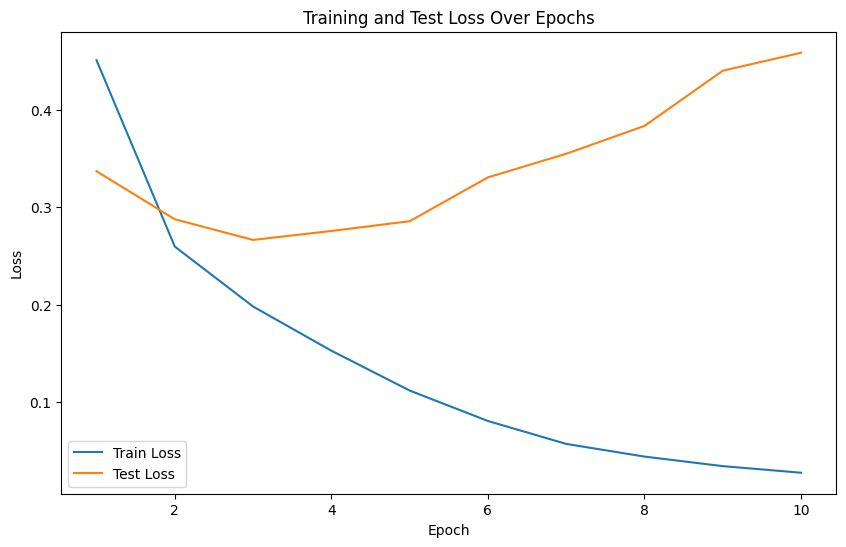

In [70]:
# Plot the training and test losses over epochs. Notice the over-fitting.
plt.figure(figsize=(10, 6))
plt.plot(range(1, NUM_EPOCHS+1), train_losses, label="Train Loss")
plt.plot(range(1, NUM_EPOCHS+1), val_losses, label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Test Loss Over Epochs")
plt.legend()
plt.show()